In [1]:
from newsapi import NewsApiClient
import pickle
import re
import numpy as np
from nltk import FreqDist
from nltk import everygrams
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
from pylab import rcParams
from dateutil import parser
from matplotlib.dates import DateFormatter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
#keys obtained from https://newsapi.org/
newsapi = NewsApiClient(api_key='a785f3dfd1e04e26b28230351629f2d8')

In [ ]:
#get the list of all english news sources
sources = newsapi.get_sources()
id=[]
for i in sources['sources']:
    if i['language']=='en':
        id.append(i['id'])

In [ ]:
#get all articles from all english news sources, only news articles from the past one month can be retrieved using the 
#free version of the news api
articles=[]
for i in id:
    all_articles = newsapi.get_everything(q='brexit',from_param='2019-04-06',to='2019-04-09',sources=i)
    articles.append(all_articles)

In [ ]:
#write out article to file so as to not use the api call everytime the code is run
with open('articles12h', 'wb') as fp:
    pickle.dump(articles, fp)

In [2]:
#read articles
with open('articles24h','rb') as fp:
    articles=pickle.load(fp)


In [8]:
#remove empty articles from article list
while [] in articles:
    articles.remove([])
for i in articles:
    if i['totalResults']==0:
        articles.remove(i)
        

In [9]:
#import stopword list
with open('sw1.txt','r') as f:
    stop_words=f.readlines()
    for i in range(len(stop_words)):
        stop_words[i]=stop_words[i].rstrip().lower()

In [10]:
#Conver the api response into a list of news article headlines. A lot duplicate articles which are present are also removed
x=[]
news=[]
article_time_list=[]

for i in articles:
    if i['articles'][0]['source']['name'] not in x:
        x.append(i['articles'][0]['source']['name'])
        
        i=i['articles']
        sum=0
        for j in i:
            article_time=j['publishedAt']
            j=j['title']
            j=j.lower()
            j=j.replace('’','\'')
            j=j.split()
            j = [w for w in j if not w in stop_words]
            j=" ".join(j)
            j = re.sub(r'[^\w\s]','',j)
    
            if j not in news:
                article_time_list.append(article_time)
                news.append(j)
                sum+=1
        with open('articles_per_source.txt','a') as f:
            f.write(i[0]['source']['name']+'\t'+str(sum)+'\n')



In [11]:
#Topics are read and processed
with open('topics24h','r') as f:
    topics=f.readlines()

for i in range(len(topics)):
    topics[i]=topics[i].rstrip()
    topics[i] = re.sub(r'[^\w\s]','',topics[i])
    topics[i]=topics[i].split()
    topics[i]=list(set(topics[i]))
    if 'http' in topics[i]:
        topics[i].remove('http')
    if 'https' in topics[i]:
        topics[i].remove('https')
    topics[i]=" ".join(topics[i])
topics=list(set(topics))

In [12]:
#Function to get jacaard's similarity between two strings
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
#Calculating jaccard similarity between news headlines and topics detected by our algorithm
x=[]
sum=0
for i in topics:
    for j in news:
        if get_jaccard_sim(i,j)>0.2:
            x.append(i)
            print(i,'\n',j,'\n')
            sum+=1
            break


In [ ]:
#Calculating TF-IDF score between each topic detected by our algorithm and all news headlines.
tfidf_vectorizer = TfidfVectorizer()
sum=0
for i in topics:
    news.append(i)
    tfidf_matrix = tfidf_vectorizer.fit_transform(news)
    a=cosine_similarity(tfidf_matrix[-1], tfidf_matrix)[0][:-1]
    del news[-1]
    if max(a)>0.25:
        sum+=1
        x.append(i)
        print(i,'\n',news[np.argmax(a)],max(a),'\n')


In [15]:
#List of all topics that has been validated with news headlines either by using Jaccard's similarity or by using TF-IDF
x=list(set(x))
x

['won brexit gerrymandering',
 'referendum al politicians uk forcing brexit stealingthevote gore annabd20 cowards globalist election res',
 'people british',
 'delivering half mike_fabricant parliament british betray people brexit clear government',
 'fighting back staff br owner livelihood tears worried upsides sturdyalex business',
 'leave labour',
 'arguments govt claim nonsense british rerun seeking eu brexit rcorbettmep',
 'elephant kicking room backstop brexit teresamays idea',
 'brexit pro',
 'delivering half parliament british betray people brexit clear government',
 'birminghams crufts',
 'queen speaks confidence optimism greater commonwealth delivers',
 'nonsense leave influence eu uk major give idea membership',
 'leave eu',
 'pm british',
 'leave voted',
 'referendum globalist al politicians uk brexit stealingthevote gore annabd20 cowards election forcing res',
 'britain brexit',
 'britain madness mps save brexit make week sign',
 'plot permanent union telegraph memo eu uk 

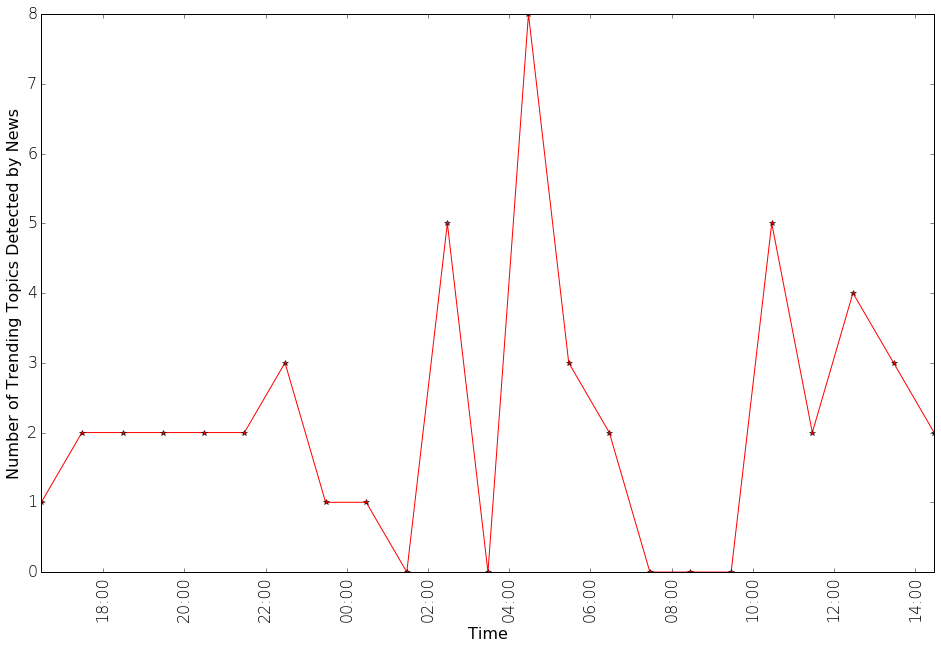

In [16]:
#extracting the necessary data to create the below graph

with open('topics24h','r') as f:
    topics=f.readlines()

time_list=[]
for i in range(len(topics)):
    topics[i]=topics[i].rstrip()
    if re.match(r'^2019',topics[i]):
        time_list.append(topics[i])
    topics[i] = re.sub(r'[^\w\s]','',topics[i])
    topics[i]=topics[i].split()
    topics[i]=list(set(topics[i]))
    if 'http' in topics[i]:
        topics[i].remove('http')
    if 'https' in topics[i]:
        topics[i].remove('https')
    topics[i]=" ".join(topics[i])
len(topics)

sum=0
y1=[]
for i in topics[1:]:
    if re.search(r'^[0-9 ]*$',i):
        y1.append(sum)
        sum=0
    if i in x:
        sum+=1
        x.remove(i)
y1.append(sum)

for i in range(len(time_list)):
    time_list[i]=parser.parse(time_list[i])
    
    
rcParams['figure.figsize'] = 12,10
formatter = DateFormatter('%H:%M')



rcParams['figure.figsize'] = 16,10
rcParams['font.size']=16
rcParams['font.weight']=4
    
    
plt.xticks(rotation=90)
plt.xlabel('Time')
plt.ylabel('Number of Trending Topics Detected by News')
plt.plot(time_list,y1,marker='*',linewidth=1,color='r')
plt.gcf().axes[0].xaxis.set_major_formatter(formatter)
plt.savefig('index.eps',format='eps')


In [17]:
#extracting data for the below graph
for i in range(len(time_list)):
    time_list[i]=str(time_list[i])
time_list

['2019-03-08 16:28:46',
 '2019-03-08 17:28:45',
 '2019-03-08 18:28:45',
 '2019-03-08 19:28:45',
 '2019-03-08 20:28:45',
 '2019-03-08 21:28:45',
 '2019-03-08 22:28:45',
 '2019-03-08 23:28:45',
 '2019-03-09 00:28:39',
 '2019-03-09 01:28:39',
 '2019-03-09 02:28:34',
 '2019-03-09 03:28:34',
 '2019-03-09 04:28:24',
 '2019-03-09 05:27:54',
 '2019-03-09 06:27:49',
 '2019-03-09 07:27:46',
 '2019-03-09 08:27:46',
 '2019-03-09 09:27:46',
 '2019-03-09 10:27:46',
 '2019-03-09 11:27:45',
 '2019-03-09 12:27:44',
 '2019-03-09 13:27:44',
 '2019-03-09 14:27:40']

In [18]:
for i in range(len(article_time_list)):
    article_time_list[i]=parser.parse(article_time_list[i])


In [19]:
from datetime import timedelta
article_time_list.sort()
time_list=[]
time_list.append(article_time_list[0])
it=article_time_list[0]
cnt=1
cnt_list=[]
for i in article_time_list[1:]:
    if i-it>timedelta(seconds=3600):
        time_list.append(i)
        it=i
        cnt_list.append(cnt)
        cnt=0
    else:
        cnt+=1

if cnt>0:
    cnt_list.append(cnt)

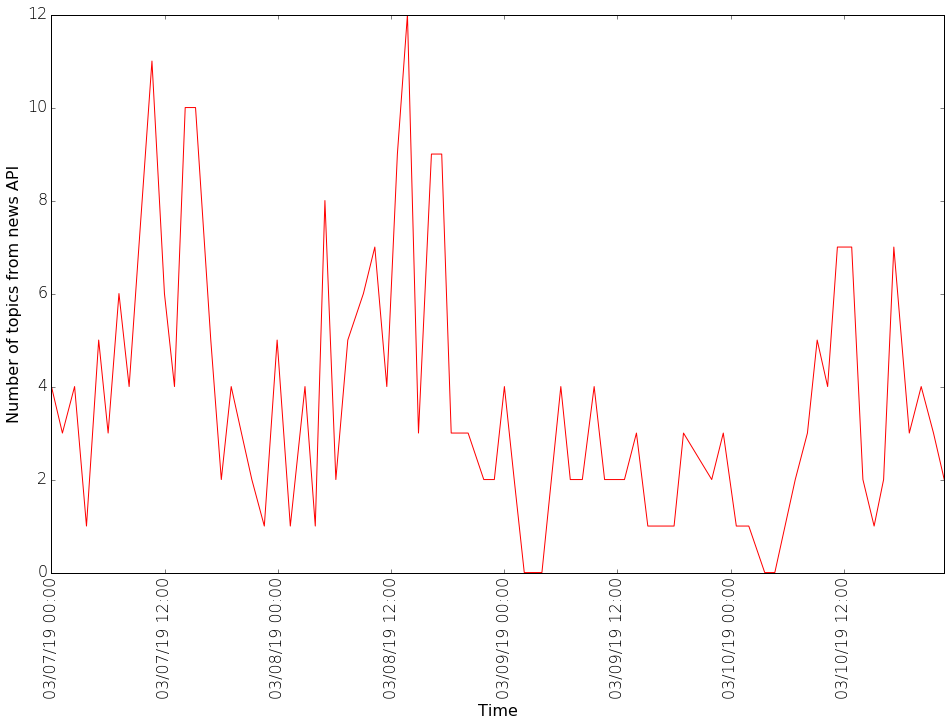

In [20]:
plt.xticks(rotation=90)
plt.xlabel('Time')
plt.ylabel('Number of topics from news API')
plt.plot(time_list,cnt_list,linewidth=1,color='r')
formatter = DateFormatter('%D %H:%M')

plt.gcf().axes[0].xaxis.set_major_formatter(formatter)
plt.savefig('index2.eps',format='eps',figsize=(12,10))